# Taller de regresión logística



In [18]:
# Imports and setup of the notebook

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns # para graficas estadisticas

from sklearn.metrics import confusion_matrix, accuracy_score # aprendisaje automatico
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression


%matplotlib inline
plt.style.use('seaborn-darkgrid')
sns.set_context("talk")

In [19]:
df = pd.read_csv("https://raw.githubusercontent.com/macc-urosario/bigdataco20/main/scripts/data/red_blood_cells_csv.csv")
# df = pd.read_csv("data/red_blood_cells.csv")
df.head()

,etiquetas,Area,Eccentricity,Solidity,Extent,Perimeter,MajorAxisLength,MinorAxisLength,Circularity,Elongation,roundnessCH,convexity,circleVariance,ellipVariance,Mean_Green,Mean_Red,Mean_Blue,Std_Green,Std_Red,Std_Blue,Skewness_G,Skewness_R,Skewness_B,Kurtosis_G,Kurtosis_R,Kurtosis_B,Entropy_G,Entropy_R,Entropy_B
0,Drepanocits,49102,0.896437,0.989860,0.766452,881.706,376.511849,166.858839,0.793709,0.556830,0.793277,1.000272,0.276134,0.103152,36682.26467,38154.84762,40788.81773,3275.881444,2695.816523,3372.995731,0.535646,0.311529,0.466719,2.398121,2.554637,2.439342,5.566492,5.399148,5.664947
1,Drepanocits,47888,0.854299,0.991634,0.725851,838.126,342.854428,178.209424,0.856679,0.480218,0.855192,1.000869,0.226761,0.065334,37343.19679,37960.50618,41332.52188,3431.515401,2530.205004,3586.067702,0.748066,0.410346,0.466982,2.809056,2.907058,2.306805,5.599119,5.313861,5.723647
2,Drepanocits,38226,0.965385,0.979175,0.545229,936.704,435.079969,113.481275,0.547475,0.739171,0.547475,1.000000,0.413123,0.057341,40797.64474,41405.90425,45203.73358,2348.755406,1925.002055,2507.724453,0.409211,0.109100,0.363423,2.541581,3.187655,2.478097,5.181426,4.945348,5.278194
3,Drepanocits,50034,0.918789,0.985833,0.580003,922.594,402.348475,158.826855,0.738676,0.605251,0.741612,0.998019,0.305336,0.046712,39144.19379,40780.25375,42492.78906,2840.443988,2392.363935,2878.509437,0.626059,0.260490,0.461162,2.945679,3.238612,2.647657,5.425858,5.233146,5.468556
4,Drepanocits,62347,0.897567,0.987800,0.780811,1009.373,427.053434,188.278760,0.768992,0.559121,0.773321,0.997197,0.283171,0.035066,34574.83593,36427.67658,40659.35824,3656.926483,2869.435942,3227.127137,0.649934,0.307376,0.345147,3.063079,2.783532,2.471924,5.776544,5.503361,5.643279


This dataset does not have qualitative features, then we are going to create a qualitative area feature based on a particular threshold value

In [22]:
df['Area_cualitativa'] = df['Area'].apply(lambda x: 'High' if x>40000 else 'Low')
#define una función usando lambda aqui separa el area en alta o baja

df.head()

,etiquetas,Area,Eccentricity,Solidity,Extent,Perimeter,MajorAxisLength,MinorAxisLength,Circularity,Elongation,roundnessCH,convexity,circleVariance,ellipVariance,Mean_Green,Mean_Red,Mean_Blue,Std_Green,Std_Red,Std_Blue,Skewness_G,Skewness_R,Skewness_B,Kurtosis_G,Kurtosis_R,Kurtosis_B,Entropy_G,Entropy_R,Entropy_B,Area_cualitativa
0,Drepanocits,49102,0.896437,0.989860,0.766452,881.706,376.511849,166.858839,0.793709,0.556830,0.793277,1.000272,0.276134,0.103152,36682.26467,38154.84762,40788.81773,3275.881444,2695.816523,3372.995731,0.535646,0.311529,0.466719,2.398121,2.554637,2.439342,5.566492,5.399148,5.664947,High
1,Drepanocits,47888,0.854299,0.991634,0.725851,838.126,342.854428,178.209424,0.856679,0.480218,0.855192,1.000869,0.226761,0.065334,37343.19679,37960.50618,41332.52188,3431.515401,2530.205004,3586.067702,0.748066,0.410346,0.466982,2.809056,2.907058,2.306805,5.599119,5.313861,5.723647,High
2,Drepanocits,38226,0.965385,0.979175,0.545229,936.704,435.079969,113.481275,0.547475,0.739171,0.547475,1.000000,0.413123,0.057341,40797.64474,41405.90425,45203.73358,2348.755406,1925.002055,2507.724453,0.409211,0.109100,0.363423,2.541581,3.187655,2.478097,5.181426,4.945348,5.278194,Low
3,Drepanocits,50034,0.918789,0.985833,0.580003,922.594,402.348475,158.826855,0.738676,0.605251,0.741612,0.998019,0.305336,0.046712,39144.19379,40780.25375,42492.78906,2840.443988,2392.363935,2878.509437,0.626059,0.260490,0.461162,2.945679,3.238612,2.647657,5.425858,5.233146,5.468556,High
4,Drepanocits,62347,0.897567,0.987800,0.780811,1009.373,427.053434,188.278760,0.768992,0.559121,0.773321,0.997197,0.283171,0.035066,34574.83593,36427.67658,40659.35824,3656.926483,2869.435942,3227.127137,0.649934,0.307376,0.345147,3.063079,2.783532,2.471924,5.776544,5.503361,5.643279,High


In [23]:
df.shape

(1656, 30)

In [24]:
df2 = df.loc[df['etiquetas']!='Drepanocits'].reset_index(drop=True) # Delete the drepanocytes
df2['etiquetas2'] = df2.etiquetas.factorize()[0] # Spherocyte is 0
df2['Area_cualitativa2'] = df2.Area_cualitativa.factorize()[0] # Low is 0

df2.etiquetas.value_counts()

Esferocito    552
Normal        552
Name: etiquetas, dtype: int64

In [25]:
df2.shape

(1104, 32)

Datos balanceados, para el ejemplo


Usamos `MajorAxisLength` y `Mean_Green` como características


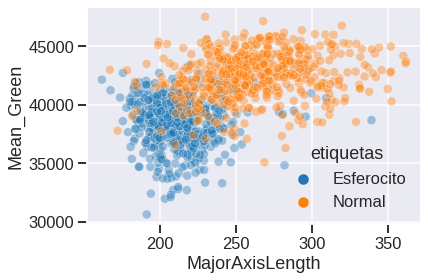

In [26]:
sns.scatterplot(x='MajorAxisLength', y='Mean_Green',hue='etiquetas', data=df2,alpha=0.4);

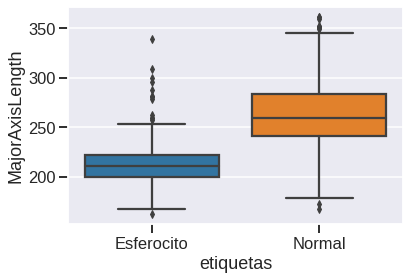

In [8]:
sns.boxplot(y='MajorAxisLength', x='etiquetas',data=df2);

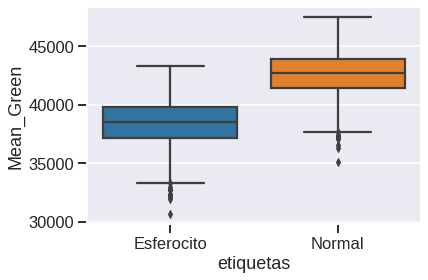

In [9]:
sns.boxplot(y='Mean_Green', x='etiquetas',data=df2);

Usando regresión lineal encontramos los problemas esperados


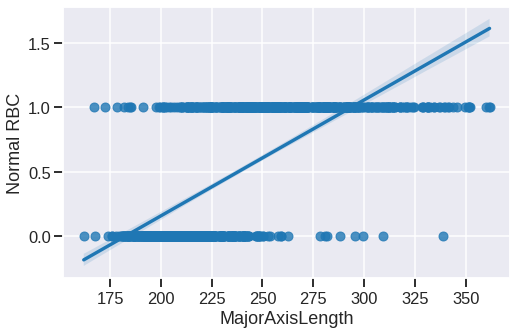

In [10]:
plt.figure(figsize=(8,5))
sns.regplot(x= 'MajorAxisLength', y='etiquetas2', data=df2)
plt.ylabel('Normal RBC')
plt.show()

#  Regresión Logística

### Usando una característica (Major Axix Length) 

In [27]:
model = LogisticRegression()
# esta definido dentro de la libreria sklearn
#aqui defino que es logistico

X_train = df2[['MajorAxisLength']]

y = df2['etiquetas']

model.fit(X_train,y)
#entreno ya diciendo que el modelo era logístico

print("classes: {}\ncoefficients: {}\nintercept: {}".format(
    model.classes_,model.coef_, model.intercept_))

classes: ['Esferocito' 'Normal']
coefficients: [[0.07414429]]
intercept: [-17.2769656]


In [28]:
#def es para función 
def coefbonito(model,X):
  #dict es un diccionario
  #ravel para unir al concatenar en columnas diferentes pero en un solo arrelgo
  #no entendi bien, en un solo numpuarray
    D = dict(coeficientes=np.c_[model.intercept_,model.coef_].ravel())
    return pd.DataFrame(D, index=['intercept']+ X.columns.to_list())

In [29]:
coefbonito(model,X_train)
#permite visualizar bien

,coeficientes
intercept,-17.276966
MajorAxisLength,0.074144


### Graficar ambas regresiones, lineal y logística

In [35]:
# We build a test array from the minimum to the maximum Major Axis Length. Then
# we calculate the classification probability for every point.
X_test = np.arange(df2.MajorAxisLength.min(), df2.MajorAxisLength.max()).reshape(-1,1)
prob = model.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


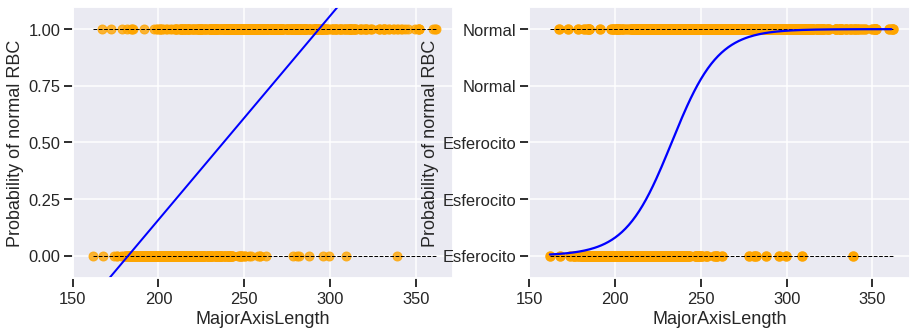

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# Left plot
sns.regplot(x=df2.MajorAxisLength, y=df2.etiquetas2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'blue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='blue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of normal RBC')
    ax.set_xlabel('MajorAxisLength')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(left=150)
    ax.set_ylim(top=1.1)
    ax.set_ylim(bottom=-0.1)

### Calculo de probabilidades

Podemos calcular la probabilidad normal de RBC de una celda con una longitud de eje principal de 200 píxeles, manualmente:

In [37]:
probability = np.exp(-17.277293+0.074146*200)/(1+np.exp(-17.277293+0.074146*200))
print(f"The normal RBC probability for a cell with a major axis length of 200 pixels is {probability:.4f}")

The normal RBC probability for a cell with a major axis length of 200 pixels is 0.0796


O usamos el método `predict_proba` de scikit-learn:

In [38]:
model.predict_proba([[200]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


array([[0.92042297, 0.07957703]])

**Cuál es la probabilidad de ser esferocitos  para una celula cuyo eje mayor es de 250 pixels?**

In [ ]:
# Respuesta
probability = np.exp(-17.277293+0.074146*250)/(1+np.exp(-17.277293+0.074146*250))
print(f"The normal RBC probability for a cell with a major axis length of 250 pixels is {probability:.4f}")


The normal RBC probability for a cell with a major axis length of 250 pixels is 0.7789


In [39]:
model.predict_proba([[250]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


array([[0.22112773, 0.77887227]])

### Regresión logística usando `Area_cualitativa`

In [ ]:
df2[['etiquetas','Area_cualitativa', 'MajorAxisLength', 'Mean_Green']].sample(3)

,etiquetas,Area_cualitativa,MajorAxisLength,Mean_Green
617,Normal,High,361.740937,43731.30649
618,Normal,Low,224.881139,39690.87441
673,Normal,High,240.635982,41960.43643


In [40]:
model = LogisticRegression()

X_train = df2[['Area_cualitativa2']]
y = df2['etiquetas']
model.fit(X_train,y)

coefbonito(model,X_train)

,coeficientes
intercept,-1.227996
Area_cualitativa2,3.207253


**Cuando la célula tiene un área grande, ¿qué tipo de glóbulos rojos será? (calcule la probabilidad)**

In [ ]:
# Respuesta
model.predict_proba([[1]])
#high es 1
# Es normal

array([[0.12139812, 0.87860188]])

**Cuando la célula tiene un área pequeña, ¿qué tipo de glóbulos rojos será? (calcule la probabilidad)**

In [ ]:
# Respuesta
model.predict_proba([[0]])
#es esferocito

array([[0.7734677, 0.2265323]])

### REgresión logística multivariable


In [41]:

from sklearn import preprocessing

model = LogisticRegression(C=1000)
X_train = df2[['MajorAxisLength','Area_cualitativa2','Mean_Green']]
#aqui usa 3 descriptores

# Se escalan los descriptores entre 0 y 1, para asegurar la convergencia.
X2 = preprocessing.scale(X_train)
#aqui está normalizando
y = df2['etiquetas']
# model.fit(X_train,y)
model.fit(X2,y)

coefbonito(model,X_train)

,coeficientes
intercept,0.401577
MajorAxisLength,2.051337
Area_cualitativa2,-0.005281
Mean_Green,2.619206


### MAtriz de confusión

Una matriz de confusión es un resumen de los resultados de predicción sobre un problema de clasificación. La cantidad de predicciones correctas e incorrectas se resumen con valores de conteo y se desglosan por cada clase. Esta es la clave de la matriz de confusión. La matriz de confusión muestra las formas en que su modelo de clasificación se confunde cuando hace predicciones. Le brinda información no solo sobre los errores que comete su clasificador sino, lo que es más importante, los tipos de errores que se cometen. Es este desglose el que supera la limitación de usar solo la precisión de la clasificación.

usamos `sklearn.metrics.confusion_matrix` y *seaborn*. 

In [ ]:
# Nice function to calculate and visualize the confusion matrix
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    if clases == None:
        clases = list(set(ytrue))
        clases.sort() # unique labels sorted alphabetically
    
    CM = confusion_matrix(ytrue,ypred, labels=clases)
    
    # Normalize the confusion matrix by dividing each row by the total of true
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Broadcasting trick
 
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualize the confusion matrix using a heatmap
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':16}, ax=ax )
    
    plt.show()

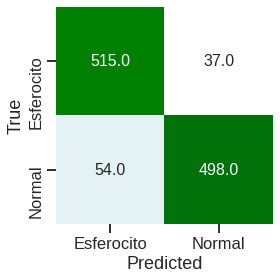

In [ ]:
plotCM(y, model.predict(X2))

**Calcule la precisión de la clasificación usando la matriz de confusión anterior**

In [42]:
#Respuesta

(515+498)/(515+37+54+498)

0.917572463768116

In [43]:
accuracy_score(y, model.predict(X2))


0.917572463768116

Pruebas con otro set de datos


In [53]:
import matplotlib.pyplot as plt
from sklearn import datasets

Se tiene datos del Iris datase, que puede encontrarse aqui: https://archive.ics.uci.edu/ml/datasets/iris. El objetivo con este dataset es tratar de identificar el tipo de flor en función de 4 parámetros. Para este primer ejemplo vamos a utilizar solamente los dos primerosrelacionados con el ancho y el largo del sépalo de la flor.

In [54]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

De los datos cargados seleccione solamente las clases 0 y 1, y grafiquelas resaltando las dos clases. 
Qué puede decir de los datos para cada clase?
Regresión Logistica Lineal
Implemente un modelo de regresión logística qu epermita clasificar las clases 0 y 1